<a href="https://colab.research.google.com/github/i-saw/MyPrograms/blob/main/%D0%9A%D0%B0%D1%80%D1%82%D0%B0_%D0%B3%D0%BB%D1%83%D0%B1%D0%B8%D0%BD%D1%8B_%D0%B8_3d_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_%D0%BF%D0%BE_%D1%81%D1%82%D0%B5%D1%80%D0%B5%D0%BE%D0%BF%D0%B0%D1%80%D0%B5%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
#!git clone -b develop https://github.com/StarkitRobots/cvr_course

In [ ]:
#!git clone https://github.com/bvnayak/stereo_calibration.git

In [ ]:
#!git clone -b develop https://github.com/kefir8888/cvr_course

In [ ]:
from google.colab import drive 
import google.colab as colab
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Stereo pair calibration

- Intrinsic_mtx_1 - матрица 1 камеры
- dist_1 - коэффициенты дисторсии 1 камеры
- Intrinsic_mtx_2 - матрица 2 камеры
- dist_2 - коэффициенты дисторсии 2 камеры

- R - матрица поворота между камерами
- T - матрица трансляции между камерами

https://github.com/bvnayak/stereo_calibration.git

In [ ]:
import numpy as np
import cv2
import glob
import argparse
from google.colab.patches import cv2_imshow
filepath = "/content/gdrive/MyDrive/Stereo_calibration/cuts/"
class StereoCalibration(object):
    def __init__(self, filepath):
        # termination criteria \ # критерии прекращения
        self.criteria = (cv2.TERM_CRITERIA_EPS +
                         cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        self.criteria_cal = (cv2.TERM_CRITERIA_EPS +
                             cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5)

        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        # подготовить точки объекта, например (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        self.objp = np.zeros((9*6, 3), np.float32)
        self.objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

        # Arrays to store object points and image points from all the images.
        # Массивы для хранения точек объектов и точек изображений всех изображений.
        self.objpoints = []  # 3d point in real world space \ 3d-точка в пространстве реального мира
        self.imgpoints_l = []  # 2d points in image plane.  \2d точки в плоскости левого изображения.
        self.imgpoints_r = []  # 2d points in image plane.  \ 2d точки в плоскости правого изображения.

        self.cal_path = filepath
        self.read_images(self.cal_path)

    def read_images(self, cal_path):
        images_right = glob.glob(cal_path + 'right*.png')
        images_left = glob.glob(cal_path + 'left*.png')
        images_left.sort()
        images_right.sort()

        print ("images_left", images_left, images_right)

        for i, fname in enumerate(images_right):
            img_l = cv2.imread(images_left[i])
            img_r = cv2.imread(images_right[i])

            gray_l = cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY)
            gray_r = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)

            # Find the chess board corners  \ Найдите углы шахматной доски
            ret_l, corners_l = cv2.findChessboardCorners(gray_l, (9, 6), None)
            ret_r, corners_r = cv2.findChessboardCorners(gray_r, (9, 6), None)

            # If found, add object points, image points (after refining them)
            # Если найдено, добавьте точки объекта, точки изображения (после их уточнения)
            self.objpoints.append(self.objp)

            if ret_l is True:
                rt = cv2.cornerSubPix(gray_l, corners_l, (11, 11),
                                      (-1, -1), self.criteria)
                self.imgpoints_l.append(corners_l)

                # Draw and display the corners \ # Нарисуйте и отобразите углы
                
                ret_l = cv2.drawChessboardCorners(img_l, (9, 6),
                                                  corners_l, ret_l)
                #cv2_imshow(img_l)
                cv2.waitKey(500)

            if ret_r is True:
                rt = cv2.cornerSubPix(gray_r, corners_r, (11, 11),
                                      (-1, -1), self.criteria)
                self.imgpoints_r.append(corners_r)

                # Draw and display the corners  \ # Нарисуйте и отобразите углы
                ret_r = cv2.drawChessboardCorners(img_r, (9, 6),
                                                  corners_r, ret_r)
                #cv2_imshow(img_r)
                cv2.waitKey(100)
            img_shape = gray_l.shape[::-1]

        rt, self.M1, self.d1, self.r1, self.t1 = cv2.calibrateCamera(
            self.objpoints, self.imgpoints_l, img_shape, None, None)
        rt, self.M2, self.d2, self.r2, self.t2 = cv2.calibrateCamera(
            self.objpoints, self.imgpoints_r, img_shape, None, None)

        self.camera_model = self.stereo_calibrate(img_shape)

    def stereo_calibrate(self, dims):
        flags = 0
        flags |= cv2.CALIB_FIX_INTRINSIC
        # flags |= cv2.CALIB_FIX_PRINCIPAL_POINT
        flags |= cv2.CALIB_USE_INTRINSIC_GUESS
        flags |= cv2.CALIB_FIX_FOCAL_LENGTH
        # flags |= cv2.CALIB_FIX_ASPECT_RATIO
        flags |= cv2.CALIB_ZERO_TANGENT_DIST
        # flags |= cv2.CALIB_RATIONAL_MODEL
        # flags |= cv2.CALIB_SAME_FOCAL_LENGTH
        # flags |= cv2.CALIB_FIX_K3
        # flags |= cv2.CALIB_FIX_K4
        # flags |= cv2.CALIB_FIX_K5

        stereocalib_criteria = (cv2.TERM_CRITERIA_MAX_ITER +
                                cv2.TERM_CRITERIA_EPS, 100, 1e-5)
        ret, M1, d1, M2, d2, R, T, E, F = cv2.stereoCalibrate(
            self.objpoints, self.imgpoints_l,
            self.imgpoints_r, self.M1, self.d1, self.M2,
            self.d2, dims,
            criteria=stereocalib_criteria, flags=flags)

        print('Intrinsic_mtx_1', M1)
        print('dist_1', d1)
        print('Intrinsic_mtx_2', M2)
        print('dist_2', d2)
        print('R', R)
        print('T', T)
        print('E', E)
        print('F', F)

        # for i in range(len(self.r1)):
        #     print("--- pose[", i+1, "] ---")
        #     self.ext1, _ = cv2.Rodrigues(self.r1[i])
        #     self.ext2, _ = cv2.Rodrigues(self.r2[i])
        #     print('Ext1', self.ext1)
        #     print('Ext2', self.ext2)

        print('')

        camera_model = dict([('M1', M1), ('M2', M2), ('dist1', d1),
                            ('dist2', d2), ('rvecs1', self.r1),
                            ('rvecs2', self.r2), ('R', R), ('T', T),
                            ('E', E), ('F', F)])

        cv2.destroyAllWindows()
        return camera_model
#if __name__ == '__main__':
     #parser = argparse.ArgumentParser()
     #parser.add_argument('filepath', help='String Filepath')
     #args = parser.parse_args()
     #cal_data = StereoCalibration(args.filepath)


In [ ]:
#from stereo_calibration.camera_calibrate import StereoCalibration

cal = StereoCalibration(filepath)
cal.camera_model

images_left ['/content/gdrive/MyDrive/Stereo_calibration/cuts/left-1.png', '/content/gdrive/MyDrive/Stereo_calibration/cuts/left-10.png', '/content/gdrive/MyDrive/Stereo_calibration/cuts/left-11.png', '/content/gdrive/MyDrive/Stereo_calibration/cuts/left-12.png', '/content/gdrive/MyDrive/Stereo_calibration/cuts/left-13.png', '/content/gdrive/MyDrive/Stereo_calibration/cuts/left-14.png', '/content/gdrive/MyDrive/Stereo_calibration/cuts/left-15.png', '/content/gdrive/MyDrive/Stereo_calibration/cuts/left-16.png', '/content/gdrive/MyDrive/Stereo_calibration/cuts/left-17.png', '/content/gdrive/MyDrive/Stereo_calibration/cuts/left-18.png', '/content/gdrive/MyDrive/Stereo_calibration/cuts/left-19.png', '/content/gdrive/MyDrive/Stereo_calibration/cuts/left-2.png', '/content/gdrive/MyDrive/Stereo_calibration/cuts/left-20.png', '/content/gdrive/MyDrive/Stereo_calibration/cuts/left-21.png', '/content/gdrive/MyDrive/Stereo_calibration/cuts/left-22.png', '/content/gdrive/MyDrive/Stereo_calibration/

{'M1': array([[1.06293738e+03, 0.00000000e+00, 1.12528151e+03],
        [0.00000000e+00, 1.06156860e+03, 6.19494198e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'M2': array([[1.05717129e+03, 0.00000000e+00, 1.11633501e+03],
        [0.00000000e+00, 1.05626218e+03, 6.30727533e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'dist1': array([[-1.04653712e-01,  1.29483327e-01,  2.87863349e-04,
          8.06681557e-05, -6.80377664e-02]]),
 'dist2': array([[-0.09867552,  0.10972175, -0.00020302,  0.00067983, -0.05495891]]),
 'rvecs1': (array([[-0.17952577],
         [-0.07051773],
         [ 0.01565769]]),
  array([[-0.26556121],
         [ 0.04334436],
         [ 0.15909392]]),
  array([[-0.12716702],
         [ 0.13212604],
         [ 0.11663275]]),
  array([[-0.26408336],
         [-0.11522108],
         [ 0.08082343]]),
  array([[-0.07775266],
         [ 0.39049116],
         [ 0.07931039]]),
  array([[-0.28070611],
         [ 0.00422795],
       

# Disparity map obtainment

https://github.com/OmarPadierna/3DReconstruction

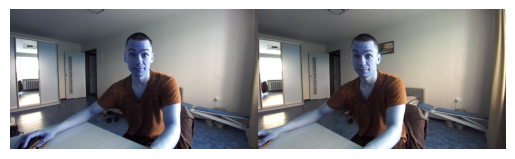

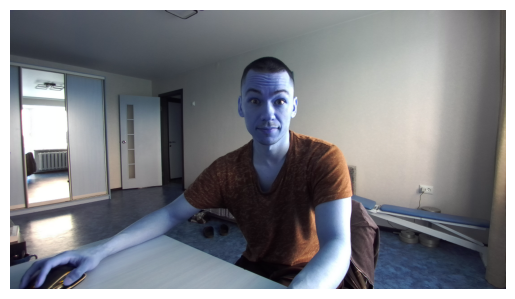

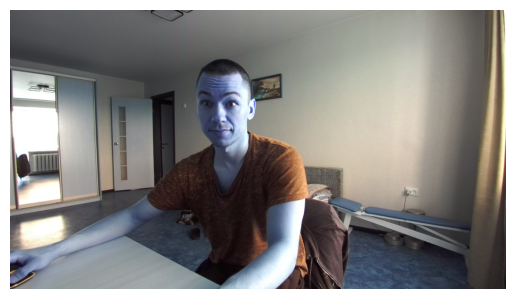


Computing the disparity  map...


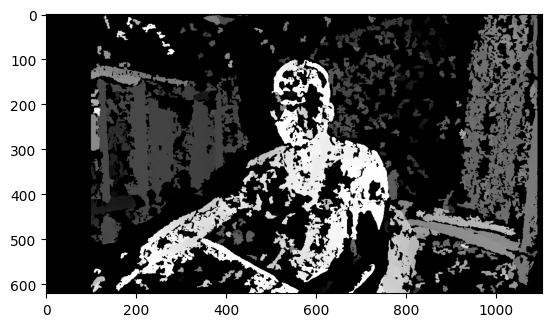

In [ ]:
import cv2
import numpy as np 
import glob
from tqdm import tqdm
import PIL.ExifTags
import PIL.Image
from matplotlib import pyplot as plt 

#=====================================
# Function declarations   \\ Декларации функций
#=====================================

#Function to create point cloud file  \\ Функция для создания файла облака точек
def create_output(vertices, colors, filename):
	colors = colors.reshape(-1,3)
	vertices = np.hstack([vertices.reshape(-1,3),colors])

	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar red
		property uchar green
		property uchar blue
		end_header
		'''
	with open(filename, 'w') as f:
		f.write(ply_header %dict(vert_num=len(vertices)))
		np.savetxt(f,vertices,'%f %f %f %d %d %d')

#Function that Downsamples image x number (reduce_factor) of times. 
#Функция, которая уменьшает выборку изображения х количество (коэффициент_уменьшения) раз.
def downsample_image(image, reduce_factor):
	for i in range(0,reduce_factor):
		#Check if image is color or grayscale   \\ Проверить, является ли изображение цветным или полутоновым
		if len(image.shape) > 2:
			row,col = image.shape[:2]
		else:
			row,col = image.shape

		image = cv2.pyrDown(image, dstsize= (col//2, row // 2))
	return image


img = cv2.imread ("/content/gdrive/MyDrive/Stereo_calibration/Explorer_HD2K_SN36068989_13-29-41.png")

plt.imshow (img)
plt.axis ('off')
plt.show ()
#img_downsampled = cv2.resize (img, (512, 192))
img_downsampled = cv2.resize (img, (2208, 621))

img_1_downsampled = img_downsampled [:, :1104, :]
img_2_downsampled = img_downsampled [:, 1104:, :]

plt.imshow (img_1_downsampled)
plt.axis ('off')
plt.show ()

plt.imshow (img_2_downsampled)
plt.axis ('off')
plt.show ()

#Set disparity parameters
#Note: disparity range is tuned according to specific parameters obtained through trial and error. 
#диапазон несоответствия настраивается в соответствии с конкретными параметрами, полученными методом проб и ошибок.
win_size = 1
min_disp = -10
max_disp = 100 #min_disp * 9
num_disp = max_disp - min_disp # Needs to be divisible by 16 \Должно быть кратно 16

#Create Block matching object. \ Создайте объект, соответствующий блоку.
stereo = cv2.StereoSGBM_create(minDisparity= min_disp,
	numDisparities = num_disp,
	blockSize = 11,
	uniquenessRatio = 5,
	speckleWindowSize = 100,
	speckleRange = 2,
	disp12MaxDiff = 1,

	P1 = 8*3*win_size**2,#8*3*win_size**2,
	P2 =32*3*win_size**2) #32*3*win_size**2)

#Compute disparity map   \ Вычислить карту несоответствий
print ("\nComputing the disparity  map...")
disparity_map = stereo.compute(img_1_downsampled, img_2_downsampled)

#Show disparity map before generating 3D cloud to verify that point cloud will be usable. 
#Покажите карту несоответствий перед созданием 3D-облака, чтобы убедиться, что облако точек можно использовать.
plt.imshow(disparity_map,'gray')
plt.show()

# Point cloud generation

In [ ]:
#Generate point cloud.  \ Сгенерируйте облако точек.
print ("\nGenerating the 3D map...")

#Get new downsampled width and height  \\ Получение новой уменьшенной ширины и высоты
h,w = img_2_downsampled.shape[:2]

#Load focal length.  \\ Фокусное расстояние нагрузки.
#focal_length = np.load('./camera_params/FocalLength.npy')
focal_length = 2100

#Perspective transformation matrix  \\ Матрица преобразования перспективы
#This transformation matrix is from the openCV documentation, didn't seem to work for me. 
#Эта матрица преобразования взята из документации openCV, мне она не подошла.
# Q = np.float32([[1,0,0,-w/2.0],
# 				[0,-1,0,h/2.0],
# 				[0,0,0,-focal_length],
# 				[0,0,1,0]])

#This transformation matrix is derived from Prof. Didier Stricker's power point presentation on computer vision. 
#Эта матрица преобразования взята из презентации профессора Дидье Стрикера по компьютерному зрению.
#Link : https://ags.cs.uni-kl.de/fileadmin/inf_ags/3dcv-ws14-15/3DCV_lec01_camera.pdf
# Q2 = np.float32([[1,0,0,0],
# 				[0,-1,0,0],
# 				[0,0,focal_length*0.05,0], #Focal length multiplication obtained experimentally. \\Умножение фокусного расстояния, полученное экспериментально.
# 				[0,0,0,1]])

M1 = cal.camera_model ["M1"]
M2 = cal.camera_model ["M1"]
D1 = cal.camera_model ["dist1"]
D2 = cal.camera_model ["dist2"]
R = cal.camera_model ["R"]
T = cal.camera_model ["T"]

R1, R2, P1, P2, Q, roi_left, roi_right = cv2.stereoRectify(M1, D1,
    M2, D2, (h, w), R, T, flags=cv2.CALIB_ZERO_DISPARITY, alpha=0.9)

print ("Q", Q)

#Reproject points into 3D  \\ Проецирование точек в 3D
points_3D = cv2.reprojectImageTo3D(disparity_map, Q)

#Get color points  \\ Получение цветовых очков
colors = cv2.cvtColor(img_1_downsampled, cv2.COLOR_BGR2RGB)

#Get rid of points with value 0 (i.e no depth) \\Избавьтесь от точек со значением 0 (т.е. без глубины)
mask_map = disparity_map > disparity_map.min()

#Mask colors and points. \\Цвета и точки масок.
output_points = points_3D[mask_map]
output_colors = colors[mask_map]

#Define name for output file \\ Определите имя выходного файла
output_file = 'reconstructed.ply'

#Generate point cloud \\Генерировать облако точек
#print ("\n Creating the output file... \n")
create_output(output_points, output_colors, output_file)

print (output_points)
print (len (output_points))


Generating the 3D map...
Q [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -1.28781767e+03]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -6.78892918e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.63478920e+02]
 [ 0.00000000e+00  0.00000000e+00  4.21167892e-01 -0.00000000e+00]]
[[-6.0501637 -4.7549543  4.646995 ]
 [-5.9901495 -4.713244   4.6062317]
 [-5.8800483 -4.6319814  4.526814 ]
 ...
 [-1.2394943 -0.2501474  2.8181238]
 [-1.2352469 -0.2501474  2.8181238]
 [-1.2309994 -0.2501474  2.8181238]]
244338
